# Catalog testing

**Author:** Xavier R Nogueira

**Overview:** The intake catalog will be the core of our first server implementation. Reading data descriptions, drivers, and locations from the catalog will allow xpublish to meet the expected OPeNDAP endpoint functionality. Later on we will also (potentially) implement read-in from a STAC catalog.

In [1]:
import intake
import panel
from pathlib import Path

In [3]:
INTAKE_CATALOG_DIR = Path.cwd().parent / 'intake_catalogs'

# find a YAML intake catalogs
intake_yamls = []
for cat in INTAKE_CATALOG_DIR.iterdir():
    if cat.suffix == '.yml':
        intake_yamls.append(cat)
print(intake_yamls)

[WindowsPath('C:/Users/xrnogueira/Documents/Xpublish-OPeNDAP-Server/intake_catalogs/sample_zarr_catalog.yml')]


In [4]:
catalog = intake.open_catalog(intake_yamls[0])
catalog

sample_zarr_catalog:
  args:
    path: C:\Users\xrnogueira\Documents\Xpublish-OPeNDAP-Server\intake_catalogs\sample_zarr_catalog.yml
  description: ''
  driver: intake.catalog.local.YAMLFileCatalog
  metadata: {}


Column(width_policy='max')
    [0] Row(width_policy='max')
        [0] PNG(str)
        [1] Column(width_policy='max')
            [0] Column(name='Select Catalog')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options={'sample_zarr_catalog': <...}, size=9, value=[<Intake catalog: s...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='＋', width=50)
                [1] Button(name='―', width=50)
                [2] Toggle(name='🔍', width=50)
        [2] Column(width_policy='max')
            [0] Column(name='Select Data Source')
                [0] Markdown(str, max_height=40)
                [1] MultiSelect(min_width=200, options=OrderedDict([('conus404-ho...]), size=9, value=[name: conus404-hourly-s3
...], width_policy='min')
            [1] Row(name='Controls')
                [0] Toggle(name='📊', width=50)
                [1] Toggle(disabled=True, name='⚙', width=50)
        [3] Column(height=240, name='Description', scroll=True, sizing_mode='stretch_width', width_policy='max')
            [0] Markdown(str)
    [1] Row(width_policy='max')
        [0] Row(height_policy='min', max_width=5000, name='Search', width_policy='max')
        [1] Column(max_width=5000, name='Add Catalog', width_policy='max')
        [2] Column(name='Plot', width_policy='max')
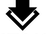

In [7]:
# check if the catalog was loaded correct
intake.interface.gui.GUI([catalog])